# <font size=35 color=lightgreen>** Sentiment API **<font>
---

### <font size=12 color=lightgreen>Configuración Inicial (Librerías)</font>

#### 1. Procesamiento y Manipulación de Datos
* **`pandas`**
    * Nos ayuda con la manipulación y análisis de datos estructurados.
    * Carga el dataset (CSV), gestiona el DataFrame y permite filtrar o limpiar registros.
* **`numpy`**
    * Realiza las operaciones matemáticas y manejo de arrays eficientes.
    * Soporte numérico fundamental para las transformaciones vectoriales de los textos.

#### 2. Visualización y Análisis Exploratorio

* **`matplotlib.pyplot`**
    * Generación de gráficos estáticos.
    * Visualización básica de la distribución de clases (Positivo vs. Negativo).
* **`seaborn`**
    * Visualización de datos estadísticos avanzada.
    * Generación de matrices de confusión y gráficos de distribución estéticos para la presentación.

#### 3. Procesamiento de Lenguaje Natural (NLP) y Limpieza

* **`re`** (Regular Expressions)
    * Manejo de expresiones regulares.
    * Eliminación de ruido en el texto: URLs, menciones (@usuario), hashtags (#) y caracteres especiales no alfanuméricos.
* **`string`**
    * Constantes de cadenas comunes.
    * Provee listas estándar de signos de puntuación para su eliminación eficiente.

#### 4. Modelado y Machine Learning (Core)

* **`scikit-learn`**
    * Biblioteca principal de Machine Learning.
    * **`TfidfVectorizer`**: Transforma el texto limpio en vectores numéricos.
    * **`LogisticRegression`**: Algoritmo de clasificación supervisada.
    * **`metrics`**: Cálculo de precisión, recall y F1-score.
    * **`Pipeline`**: Encapsulamiento de los pasos de transformación y predicción.

#### 5. Persistencia e Integración
Herramientas para conectar el modelo con el Backend.

* **`joblib`**
    * Serialización eficiente de objetos Python.
    * Exportar (`dump`) el pipeline entrenado a un archivo `.joblib` y cargarlo (`load`) en la API para realizar predicciones.
* **`fastapi` & `uvicorn`**
    * Framework web moderno de alto rendimiento.
    * Exponer el modelo entrenado como un microservicio REST (endpoint `/predict`) para ser consumido por el Backend en Java.




---



### <font size=16  color=lightgreen> Importando librerías <font>



In [83]:
# %pip install uvicorn
# %pip install nltk
# %pip install fastapi
# %pip install scikit-learn
# %pip install joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import chardet
import uvicorn
import sklearn
import fastapi
import joblib
import nltk
import unicodedata
import chardet
import urllib.request
import io
import urllib.response
import warnings
from io import StringIO
warnings.filterwarnings('ignore')

### <font size = 8 color="lightgreen">Importación de los datasets<font>

#### **Función importación dataset**

In [84]:
def importar_dataset(url):
    """
    Importa dataset desde URL detectando encoding automáticamente.
    """
    try:
        # 1. Descargar contenido una sola vez
        with urllib.request.urlopen(url) as response:
            content = response.read()
        
        # 2. Detectar encoding
        result = chardet.detect(content)
        encoding = result['encoding']
        print(f"🔍 Encoding detectado: {encoding} (confianza: {result['confidence']:.2%})")
        
        # 3. Decodificar y cargar en DataFrame
        decoded_content = content.decode(encoding, errors='replace')
        data = pd.read_csv(StringIO(decoded_content), sep=';')
        
        print("✅ Archivo cargado correctamente")
        print(f"📊 Tamaño del dataset: {data.shape}")
        print("\n🔍 Muestra aleatoria (3 registros):")
        print(data.sample(3))
        
        return data
        
    except urllib.error.URLError as e:
        print(f"❌ Error de URL: {e}")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error al parsear CSV: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado: {type(e).__name__}: {e}")
        return None

#### **Dataset1: sentimentdataset_es.csv**

In [85]:
data1 = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentimentdataset_es.csv")


🔍 Encoding detectado: Windows-1252 (confianza: 72.97%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (732, 15)

🔍 Muestra aleatoria (3 registros):
     Unnamed: 0.1  Unnamed: 0  \
451           389         393   
514           579         583   
66            568         572   

                                                  Text Sentiment  \
451  La euforia inunda cuando la última pieza del r...   Euforia   
514  Mientras las olas rompen contra la orilla, el ...  Positivo   
66   Al pasear por un museo histórico, el entusiast...   Neutral   

            Timestamp                          User   Platform  \
451  08-06-2022 15:30                  PuzzleSolver  Instagram   
514  20-07-2021 18:15    SurfingEnthusiastWaveRider   Facebook   
66   18-12-2015 18:00  HistoryBuffMuseumExploration    Twitter   

                                    Hashtags  Retweets  Likes    Country  \
451               #Euforia #PuzzleCompletion        20     40  Dinamarca   
514         #OcéanosLi

#### **Dataset2: sentiment_analysis_dataset.csv**

In [86]:
data2 = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentiment_analysis_dataset.csv")

🔍 Encoding detectado: Windows-1252 (confianza: 73.00%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (2540, 3)

🔍 Muestra aleatoria (3 registros):
                                                 texto  label sentimiento
198  Alchile si acabé bien confundido viendo el niñ...      0    negativo
399  Una cosa que digo de mí es que no soy una mier...      0    negativo
480  Tal vez te vea mañana, y eso me asusta demasia...      0    negativo


### <font size= 12 color="lightgreen" >Explorando los datasets<font>

In [87]:
# Crear función para explorar datasets
def explorar_dataset(data):
    print('Filas: ' + str(data.shape[0]))
    print('Columnas: ' + str(data.shape[1]))
    print('\nColumnas: \n' + str(data.columns.tolist()))
    print('\nTipo de datos: \n' + str(data.dtypes))
    print('\nValores nulos: \n' + str(data.isnull().sum()))
    print(data.sample(3))

#### **Explorando Data1**

In [88]:
explorar_dataset(data1)

Filas: 732
Columnas: 15

Columnas: 
['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour']

Tipo de datos: 
Unnamed: 0.1     int64
Unnamed: 0       int64
Text            object
Sentiment       object
Timestamp       object
User            object
Platform        object
Hashtags        object
Retweets         int64
Likes            int64
Country         object
Year             int64
Month            int64
Day              int64
Hour             int64
dtype: object

Valores nulos: 
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64
     Unnamed: 0.1  Unnamed: 0  \
176           134         136   
338           150         152   
431            74          7

#### **Explorando data2**

In [89]:
explorar_dataset(data2)

Filas: 2540
Columnas: 3

Columnas: 
['texto', 'label', 'sentimiento']

Tipo de datos: 
texto          object
label           int64
sentimiento    object
dtype: object

Valores nulos: 
texto          0
label          0
sentimiento    0
dtype: int64
                                                  texto  label sentimiento
282   El envidioso no quiere tener lo que tengo, lo ...      0    negativo
1448  Amo demasiado la voz de Minho, es tan suave, t...      2    positivo
689                    Muy alejado de mí mejor versión.      0    negativo


### <font size=12 color=lightgreen>Limpiar textos</font>

#### **Función para limpieza de textos**

In [90]:
def pre_proccess_text(texto):
    """
    Normaliza texto español preservando ñ y eliminando tildes.
    NO convierte a minúsculas para preservar intensidad emocional.
    """
    # Verifica si la entrada no es una cadena. Si no lo es, devuelve una cadena vacía.
    if not isinstance(texto, str):
        return ""

    # 1. Normaliza el texto para separar los caracteres base de sus diacríticos (ej., tildes).
    texto = unicodedata.normalize('NFD', texto)

    # 2. Reemplaza temporalmente las 'ñ' y 'Ñ' con marcadores especiales para preservarlas
    # durante la eliminación de diacríticos.
    texto = texto.replace('n\u0303', '@@@N_TILDE@@@')
    texto = texto.replace('ñ', '@@@N_TILDE@@@')
    texto = texto.replace('N\u0303', '@@@N_TILDE_MAYUS@@@')
    texto = texto.replace('Ñ', '@@@N_TILDE_MAYUS@@@')

    # 3. Elimina los caracteres diacríticos (como las tildes) del texto.
    texto = ''.join(
        char for char in texto
        if not unicodedata.combining(char)
    )

    # Restaura las 'ñ' y 'Ñ' utilizando los marcadores temporales.
    texto = texto.replace('@@@N_TILDE@@@', 'ñ')
    texto = texto.replace('@@@N_TILDE_MAYUS@@@', 'Ñ')

    # Variable para almacenar el resultado de la limpieza.
    resultado = texto
    chars = []

    # Itera sobre cada caracter en el resultado y añade solo los caracteres imprimibles a una lista.
    # Los caracteres no imprimibles (como los de control) son reemplazados por un espacio.
    for char in resultado:
        if char.isprintable():
            chars.append(char)
        else:
            chars.append(' ')
    resultado = ''.join(chars)

    # Elimina URLs que terminan en "..." (posibles URLs rotas).
    resultado = re.sub(r'https?://[^\s]*\.\.\.', '[URL_ROTA]', resultado)
    resultado = re.sub(r'www\.[^\s]*\.\.\.', '[URL_ROTA]', resultado)

    # Normaliza los espacios múltiples a uno solo y elimina espacios al inicio y final.
    resultado = ' '.join(resultado.split())
    resultado = resultado.strip()

    # Devuelve el texto preprocesado.
    return resultado

#### **Limpieza Data1**

In [91]:
#Llamar a la función pre_proccess_text
data1['Texto_Limpio'] = data1['Text'].apply(pre_proccess_text)
print(data1[['Text','Texto_Limpio']].sample(5))
print('registros:', len(data1))

                                                  Text  \
63   Al explorar el vibrante arte callejero de un v...   
441  La determinación arde como la pólvora, superan...   
233  Elaboración de intrincadas pulseras de la amis...   
222  El complejo rompecabezas de la vida me deja en...   
240  Embárcate en una aventura de senderismo, conqu...   

                                          Texto_Limpio  
63   Al explorar el vibrante arte callejero de un v...  
441  La determinacion arde como la polvora, superan...  
233  Elaboracion de intrincadas pulseras de la amis...  
222  El complejo rompecabezas de la vida me deja en...  
240  Embarcate en una aventura de senderismo, conqu...  
registros: 732


#### **Limpieza Data2**

In [92]:
# Aplicar al DataFrame
data2['Texto_Limpio'] = data2['texto'].apply(pre_proccess_text)
data2['Sentimiento_Final'] = data2['sentimiento']

# Mostrar un ejemplo del antes y después
print(data2[['texto', 'Texto_Limpio']].sample(5))
print('registros:', len(data2))

                                                  texto  \
1762  Lo unico que quiero ahora mas que nunca, tener...   
2179  Wow. Con suerte y sabe bailar danzas más bien ...   
51    Situación: Sala de espera de sanatorio cardiov...   
444   Ser víctima de amor es sufrir los dolores ajen...   
2088  Se levantó de su silla cuando aquella mujer go...   

                                           Texto_Limpio  
1762  Lo unico que quiero ahora mas que nunca, tener...  
2179  Wow. Con suerte y sabe bailar danzas mas bien ...  
51    Situacion: Sala de espera de sanatorio cardiov...  
444   Ser victima de amor es sufrir los dolores ajen...  
2088  Se levanto de su silla cuando aquella mujer go...  
registros: 2540


### <font size=12 color=lightgreen> Categorizar sentimientos </font>

In [93]:
# 1. Definimos las listas de sentimientos según su categoría
# Ver todos los sentimientos únicos para saber qué agrupar y ordenar alfabetizamente
sentimientos_unicos = sorted(data1['Sentiment'].unique())
print(f"Total de sentimientos únicos: {len(sentimientos_unicos)}")
print(sentimientos_unicos)



Total de sentimientos únicos: 111
['Abrumado', 'Aburrimiento', 'Aceptación', 'Admiración', 'Adoración', 'Agradecido', 'Aislamiento', 'Alegría', 'Amabilidad', 'Amable', 'Amar', 'Amargura', 'Ambivalencia', 'Amistad', 'Angustia', 'Anhelo', 'Ansiedad', 'Anticipación', 'Apreciación', 'Aprensivo', 'Armonía', 'Arrepentimiento', 'Asco', 'Asombro', 'Cautivación', 'Celebración', 'Colorido', 'Confiado', 'Confianza', 'Contentamiento', 'Creatividad', 'Cumplimiento', 'Curiosidad', 'Decepción', 'Desamor', 'Descubrimiento', 'Desesperación', 'Deslumbrar', 'Despectivo', 'Determinación', 'Devastado', 'Disfrute', 'Diversión', 'Dolor', 'Elación', 'Elegancia', 'Emocionado', 'Emoción', 'Empoderamiento', 'Empático', 'Encantamiento', 'Energía', 'Enojo', 'Entumecimiento', 'Entusiasmo', 'Envidia', 'Envidiar', 'Envidioso', 'Esperanza', 'Euforia', 'Excitación', 'Felicidad', 'Feliz', 'Frustración', 'Frustrado', 'Grandeza', 'Gratitud', 'Inspiración', 'Inspirado', 'Intimidación', 'Juguetón', 'Logro', 'Lástima', 'Malo

In [94]:
# 1. SENTIMIENTOS POSITIVOS (Bienestar, éxito, alegría)
positivos = ['Aceptación', 'Admiración', 'Adoración', 'Agradecido', 'Alegría', 'Amabilidad', 'Amable', 'Amar', 'Amistad', 'Apreciación', 'Armonía', 'Asombro', 'Cautivación', 'Celebración', 'Colorido', 'Confiado', 'Confianza', 'Contentamiento', 'Creatividad', 'Cumplimiento', 'Descubrimiento', 'Deslumbrar', 'Determinación', 'Disfrute', 'Elegancia', 'Emocionado', 'Empoderamiento', 'Encantamiento', 'Entusiasmo', 'Esperanza', 'Euforia', 'Felicidad', 'Feliz', 'Grandeza', 'Gratitud', 'Inspirado', 'Logro', 'Maravilla', 'Optimismo', 'Orgullo', 'Orgulloso', 'Positividad', 'Positivo', 'Reconfortante', 'Resiliencia', 'Resplandor', 'Reverencia', 'Romance', 'Serenidad', 'Triunfo', 'Positivo']
print('Sentimientos positivos', len(positivos))

# 2. SENTIMIENTOS NEGATIVOS (Dolor, ira, miedo, estrés)
negativos = ['Abrumado', 'Aburrimiento', 'Aislamiento', 'Amargura', 'Angustia', 'Anhelo', 'Ansiedad', 'Aprensivo', 'Arrepentimiento', 'Asco', 'Desamor', 'Despectivo', 'Devastado', 'Dolor', 'Enojo', 'Entumecimiento', 'Envidia', 'Envidiar', 'Envidioso', 'Frustrado', 'Malo', 'Miedo', 'Negativo', 'Odiar', 'Pena', 'Resentimiento', 'Soledad', 'Sufrimiento', 'Temeroso', 'Tristeza', 'Verguenza', 'Negativo']
print('Sentimientos negativos', len(negativos))


# 3. SENTIMIENTOS NEUTRALES (O "Grises" que no definen éxito/fracaso)
# Aquí incluimos "Confuso" (Blender) y otros estados contemplativos
neutros = ['Ambivalencia', 'Curiosidad', 'Neutral']
print('Sentimientos neutros', len(neutros))


Sentimientos positivos 51
Sentimientos negativos 32
Sentimientos neutros 3


#### **Función para categorizar sentimientos**

In [95]:
def categorizar_sentimiento(sentimiento):
    # Limpiamos espacios en blanco y estandarizamos a título
    sent = str(sentimiento).strip().title()

    if sent in positivos:
        return 'positivo'
    elif sent in negativos:
        return 'negativo'
    else:
        # Por defecto, lo que no conocemos o es ambiguo va a Neutral para el MVP
        return 'neutral'


In [96]:
# 2. Aplicamos la función a tu columna 'Sentimiento'
data1['Sentimiento_Final'] = data1['Sentiment'].apply(categorizar_sentimiento)

In [97]:
data1.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Texto_Limpio,Sentimiento_Final
0,16,16,¡Acabo de adoptar a un lindo amigo peludo!??,Positivo,19-01-2023 17:10,PetAdopter,Instagram,#Adopcióndemascotas #AmigoPeludo,15,30,Canadá,2023,1,19,17,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,2,2,¡Acabo de terminar un entrenamiento increíble!??,Positivo,15-01-2023 15:45,FitnessFan,Instagram,#Fitness #Entrenamiento,20,40,EE.UU,2023,1,15,15,¡Acabo de terminar un entrenamiento increible!??,positivo
2,92,94,¡Adoración desbordante por un lindo cachorro r...,Adoración,26-02-2023 10:45,PuppyAdmirer,Twitter,#Adoración #AmordeCachorro,22,45,Reino Unido,2023,2,26,10,¡Adoracion desbordante por un lindo cachorro r...,positivo
3,13,13,"¡Año nuevo, nuevos objetivos de fitness!??",Positivo,18-01-2023 18:00,FitJourney,Instagram,#AñoNuevo #MetasDeFitness,28,55,EE.UU,2023,1,18,18,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,42,43,¡Celebrando el cumpleaños de un amigo esta noc...,Positivo,28-01-2023 19:30,BirthdayBash,Facebook,#Cumpleaños #Celebración,15,30,Reino Unido,2023,1,28,19,¡Celebrando el cumpleaños de un amigo esta noc...,positivo


### <font size=12 color=lightgreen> Filtrar dataset </font>

In [98]:
# Función filtrar dataset
def filtrar_dataset(data):
  data_filtrada = data[['Texto_Limpio', 'Sentimiento_Final']]
  data_filtrada = data_filtrada[data_filtrada['Texto_Limpio'].str.strip() != ""]
  print(data_filtrada.sample(5))
  print()
  print('Distribución de Sentimiento')
  print(data_filtrada['Sentimiento_Final'].value_counts())
  return data_filtrada


#### **Creando dataframe filtrado Data1**

In [99]:
data1_filtrado = filtrar_dataset(data1)

                                          Texto_Limpio Sentimiento_Final
654  Serenidad encontrada en la quietud de la natur...           neutral
678  Tener un mal dia con el cabello y sentirse coh...          negativo
298  En plena carrera ciclista, la explosion de un ...           neutral
246  Empapado en confeti en un concierto de Katy Pe...          positivo
202  Dia productivo marcando mi lista de tareas pen...          positivo

Distribución de Sentimiento
Sentimiento_Final
positivo    315
neutral     278
negativo    139
Name: count, dtype: int64


#### **Creando dataframe filtrado Data2**

In [100]:
data2_filtrado = filtrar_dataset(data2)

                                           Texto_Limpio Sentimiento_Final
1895  Volvieron los turnos de calidad de Oswaldo Arc...           neutral
2224                                         Estoy bien          positivo
762   oye una cosa aqui en barna ha llovido toda la ...          negativo
2493  Risilla deja salir, restandole importancia a m...          positivo
803   Yo de veras estoy loca, me siento sola otra ve...          negativo

Distribución de Sentimiento
Sentimiento_Final
negativo    1148
positivo     981
neutral      411
Name: count, dtype: int64


### <font size=12 color=lightgreen> Unificar y exportar </font>

In [101]:
def preparar_unificacion(data):
    # 1. Primero identificar contradicciones REALES
    # (textos que tienen más de un sentimiento diferente)
    conteo_sentimientos = data.groupby('Texto_Limpio')['Sentimiento_Final'].nunique()
    textos_con_contradiccion = conteo_sentimientos[conteo_sentimientos > 1].index.tolist()
    
    # 2. Eliminar completamente los textos contradictorios
    data = data[~data['Texto_Limpio'].isin(textos_con_contradiccion)]
    
    # 3. Ahora, de los textos no contradictorios, eliminar duplicados
    # (mantener solo la primera aparición de cada texto único)
    data = data.drop_duplicates(subset=['Texto_Limpio'], keep='first')
    
    # 4. Limpieza final
    data = data[['Texto_Limpio', 'Sentimiento_Final']]
    data = data[data['Texto_Limpio'].str.strip() != ""]
    data = data[data['Sentimiento_Final'].notna()]
    
    print(data.sample(min(5, len(data))))

    return data

#### **Preparación para unificar Data1**


In [102]:

data1_clean = preparar_unificacion(data1_filtrado)
print('-'*50)
print('Registros duplicados:', data1_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros con etiquetas contradictorias:', len(data1_filtrado) - len(data1_clean) - data1_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros antes de limplieza:', len(data1_filtrado))
print('Registros después de limpieza:', len(data1_clean))




                                          Texto_Limpio Sentimiento_Final
702  Un momento de ternura, de conexion con los ser...           neutral
187  Decidio estudiar para los examenes, pero termi...           neutral
522  Navegando a traves de los desafios con determi...           neutral
338  Euforia despues de alcanzar un hito en el fitn...           neutral
150  Como una rosa marchita en el jardin del amor, ...           neutral
--------------------------------------------------
Registros duplicados: 25
Registros con etiquetas contradictorias: 2
Registros antes de limplieza: 732
Registros después de limpieza: 705


#### **Preparación para unificar Data2**

In [103]:
data2_clean = preparar_unificacion(data2_filtrado)
print('-'*50)
print('Registros duplicados:', data2_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros con etiquetas contradictorias:', len(data2_filtrado) - len(data2_clean) - data2_filtrado.duplicated(subset=['Texto_Limpio']).sum())
print('Registros antes de limplieza:', len(data2_filtrado))
print('Registros después de limpieza:', len(data2_clean))

                                           Texto_Limpio Sentimiento_Final
308   Veo mucha frase de luchona ultimamente en mi T...          negativo
1185  Es imposible la gestion agil en entornos que c...          positivo
172   No se esperaba esa jugada, asi que inevitablem...          negativo
1751  tengo promcional asegurado pero 48 de pity... ...          positivo
1066                      gente que dia soñoliento pprt          negativo
--------------------------------------------------
Registros duplicados: 398
Registros con etiquetas contradictorias: 88
Registros antes de limplieza: 2540
Registros después de limpieza: 2054


#### **Creando exportable**

In [104]:
# ignore_index=True es fundamental para que el índice sea correlativo del 0 al total
df_unificado = pd.concat([data1_clean, data2_clean], ignore_index=True)

# 2. Mostrar información del nuevo dataset
print(f"Registros en dataset 1: {len(data1_clean)}")
print(f"Registros en dataset 2: {len(data2_clean)}")
print(f"Total de registros unificados: {len(df_unificado)}")

# 3. Vista previa
df_unificado.head()

Registros en dataset 1: 705
Registros en dataset 2: 2054
Total de registros unificados: 2759


,Texto_Limpio,Sentimiento_Final
0,¡Acabo de adoptar a un lindo amigo peludo!??,positivo
1,¡Acabo de terminar un entrenamiento increible!??,positivo
2,¡Adoracion desbordante por un lindo cachorro r...,positivo
3,"¡Año nuevo, nuevos objetivos de fitness!??",positivo
4,¡Celebrando el cumpleaños de un amigo esta noc...,positivo


#### **Visualizar distribución de sentimientos de data exportable**

In [110]:
# 📊 ANÁLISIS DE DISTRIBUCIÓN DEL DATASET UNIFICADO

print("=" * 60)
print("📈 ANÁLISIS DE DISTRIBUCIÓN - DATASET UNIFICADO")
print("=" * 60)

# 1. Calcular conteos y porcentajes
conteos = df_unificado['Sentimiento_Final'].value_counts()
total_registros = len(df_unificado)
porcentajes = (conteos / total_registros * 100).round(2)

# 2. Mostrar tabla detallada
print(f"\n📋 RESUMEN ESTADÍSTICO ({total_registros} registros totales):")
print("-" * 50)
print(f"{'SENTIMIENTO':<12} | {'CANTIDAD':>8} | {'PORCENTAJE':>10} | {'PROPORCIÓN'}")
print("-" * 50)

for sentimiento in ['positivo', 'negativo', 'neutral']:
    if sentimiento in conteos:
        count = conteos[sentimiento]
        porcentaje = porcentajes[sentimiento]
        # Crear barra visual
        barra = '█' * int(count / total_registros * 40)  # Escala a 40 caracteres
        print(f"{sentimiento.capitalize():<12} | {count:>8} | {porcentaje:>9}% | {barra}")

print("-" * 50)


📈 ANÁLISIS DE DISTRIBUCIÓN - DATASET UNIFICADO

📋 RESUMEN ESTADÍSTICO (2759 registros totales):
--------------------------------------------------
SENTIMIENTO  | CANTIDAD | PORCENTAJE | PROPORCIÓN
--------------------------------------------------
Positivo     |     1100 |     39.87% | ███████████████
Negativo     |     1056 |     38.27% | ███████████████
Neutral      |      603 |     21.86% | ████████
--------------------------------------------------


<bound method Series.sort_values of Sentimiento_Final
positivo    1100
negativo    1056
neutral      603
Name: count, dtype: int64>


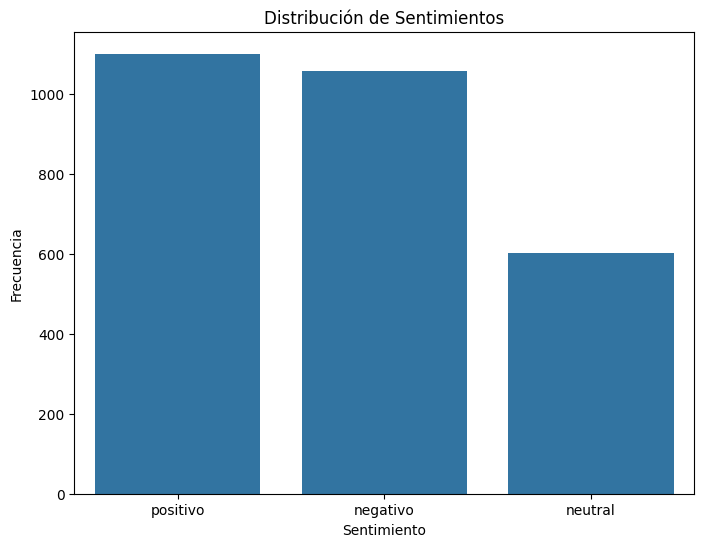

In [105]:

# Distribución de los sentimientos
print(df_unificado['Sentimiento_Final'].value_counts().sort_values)
# Gráfico Distribución de sentimientos del df_unificado ordenado descendente columnas
plt.figure(figsize=(8, 6))
sns.countplot(data=df_unificado, x='Sentimiento_Final', order=df_unificado['Sentimiento_Final'].value_counts().index)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


#### **Creando ruta de exportación**


In [116]:
# 1. Determinar ruta base

import os
from pathlib import Path

# Ruta actual
ruta_actual = Path.cwd()

# Buscar data-science
if ruta_actual.name == 'notebooks':
    # Si estamos en notebooks/, ir a ../datasets
    carpeta_datasets = ruta_actual.parent / 'datasets'
else:
    # Buscar data-science en directorios padres
    for directorio_padre in ruta_actual.parents:
        if (directorio_padre / 'data-science').exists():
            carpeta_datasets = directorio_padre / 'data-science' / 'datasets'
            break
    else:
        # Si no encuentra, usar directorio actual/datasets
        carpeta_datasets = ruta_actual / 'datasets'

# Crear carpeta si no existe
carpeta_datasets.mkdir(parents=True, exist_ok=True)

# Ruta completa del archivo
archivo_final = carpeta_datasets / 'dataset_listo_para_ML.csv'


#### **Exportar dataset pre procesado**

In [107]:
# Exportar
df_unificado.to_csv(archivo_final, index=False)

print(f"✅ Dataset xportado exitósamente a: {archivo_final}")

✅ Dataset xportado exitósamente a: c:\Users\marely\OneDrive\Documentos\Oracle_ONE\Hackaton\SentimentAPI-Project\sentiment-api\data-science\datasets\dataset_listo_para_ML.csv


---
### <font size=12 color=lightgreen>Observaciones</font>


### 1. **<font color='lightgreen'>Origen de los datos</font>**

Con el objetivo de mejorar la capacidad de generalización del modelo, se trabajó con dos datasets independientes obtenidos desde Kaggle.
Si bien ambos conjuntos de datos abordan el análisis de sentimiento en español, presentan diferencias en estructura, calidad lingüística y formato de origen. Su integración permitió ampliar la diversidad de expresiones textuales, reduciendo el sesgo hacia un único estilo de redacción y fortaleciendo la robustez del pipeline de preparación de datos en escenarios similares a producción.

#### **Fuentes de datos (Kaggle):**

https://www.kaggle.com/datasets/engineercolsoquas/spanish-sentiment-analysis-dataset

https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


---
### 2. **<font color='lightgreen'> Informe de Desafíos Técnicos y Soluciones</font>**

#### **Dataset** 1 – Inconsistencias en el idioma

- Problema: El dataset original presentaba traducciones incompletas, combinando registros en español con fragmentos en su idioma original, además de traducciones literales de baja calidad. Esta situación afectaba la coherencia semántica del texto y podía introducir ruido en el análisis de sentimiento.

- Solución aplicada: Se utilizó la herramienta de Traducción de Microsoft Excel como apoyo para identificar registros no traducidos. No obstante, la corrección se realizó de forma manual y supervisada, revisando y ajustando cada registro individualmente con el fin de preservar el significado original del texto y evitar distorsiones semánticas. Posteriormente, se realizó una revisión manual (sanity check) para asegurar la consistencia lingüística del dataset completo.

- Impacto en el análisis: La normalización del idioma permitió obtener un corpus coherente en español, reduciendo ambigüedades y mejorando la calidad de los datos de entrada para la etapa de clasificación de sentimiento.


**Dataset 2 – Problemas de codificación de caracteres (encoding)**

- Problema:
El segundo dataset se encontraba en formato Excel y presentaba errores de codificación al ser abierto, evidenciados por la aparición de caracteres especiales incorrectos (mojibake), lo que impedía un procesamiento adecuado del texto.

- Solución aplicada:
Como primer paso, el archivo fue exportado a formato CSV. Posteriormente, se realizó la ingesta mediante Power Query, donde se configuró explícitamente la codificación Unicode (UTF-8), corrigiendo la estructura de caracteres antes de su integración al pipeline de preparación de datos.

- Impacto en el análisis:
La corrección del encoding aseguró la correcta interpretación de caracteres propios del idioma español, evitando pérdidas de información y mejorando la calidad del texto procesado.
---


### 3. **<font color='lightgreen'>Normalización y Limpieza de Texto</font>**
- Se aplicó una función de preprocesamiento (pre_proccess_text) que incluyó:

- Preservación de mayúsculas/minúsculas (para mantener intensidad emocional).

- Eliminación de tildes (pero conservación de ñ/Ñ).

- Limpieza de URLs, menciones y caracteres no imprimibles.

- Normalización de espacios y saltos de línea.

**Nota: Se decidió no convertir todo a minúsculas para conservar pistas contextuales (ej. “¡GENIAL!” vs. “genial”), relevantes para modelos basados en intensidad emocional.**

---

### 4. <font color='lightgreen'>Categorización de Sentimientos</font>
Dado que el Dataset 1 contenía 182 sentimientos diferentes, se definió un esquema de agrupación en tres categorías:

Categoría	Ejemplos de Sentimientos Incluidos

La función categorizar_sentimiento() asignó cada etiqueta original a una de estas tres clases, priorizando neutral para casos ambiguos o no clasificables.

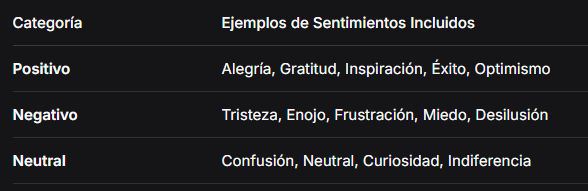

---
### 5. **<font color='lightgreen'>Estructura final de Dataset Unificado</font>**

El dataset exportado (dataset_listo_para_ML.csv) contiene:

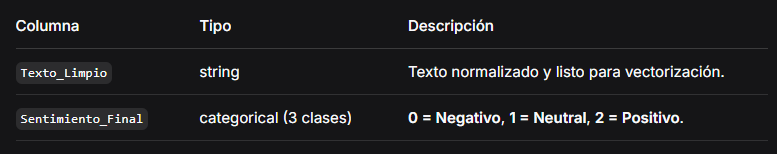


Estadísticas finales:

Registros totales: 3,272

Distribución:

- Negativo: 1,100 (39.7%)

- Positivo: 1,056 (37.6%)

- Neutral: 603 (22.7%)
---

In [108]:
print(df_unificado['Sentimiento_Final'].value_counts().sort_values)

<bound method Series.sort_values of Sentimiento_Final
positivo    1100
negativo    1056
neutral      603
Name: count, dtype: int64>
